* [how-to-use-tensorboard-with-pytorch](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-tensorboard-with-pytorch.md)
* [Pytorch TensorBoard Tutorial](https://www.youtube.com/watch?v=RLqsxWaQdHE)
* [Using Tensorboard in Pytorch](https://krishansubudhi.github.io/deeplearning/2020/03/24/tensorboard-pytorch.html)

In [1]:
import os
import sys
from itertools import (
    product
)
from typing import (
    List,
    Union,
)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix
)
import torch
from torch import nn
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.tensorboard import (
    SummaryWriter,
)

In [2]:
%load_ext tensorboard

In [3]:
%load_ext autoreload
%autoreload 2

from main import (
    tensorboard_write_histogram,
    tensorboard_write_graph,
    tensorboard_write_image,
    tensorboard_write_scalar,
    plot_confusion_matrix,
    tensorboard_write_confusion_matrix,
)

In [4]:
def get_image_data_mean_std(
        loader: DataLoader
):
    """Compute the mean and standard deviation of all pixels in the dataset.
    https://saturncloud.io/blog/how-to-normalize-image-dataset-using-pytorch/

    Args:
        loader: data loader

    Returns: (mean, std) where mean.shape=(3,) and std.shape=(3,)
    """
    count: int = 0
    mean: float = 0.0
    std: float = 0.0

    for images, _ in loader:
        assert images.ndim == 4
        batch_size, num_channels, height, width = images.shape
        # --------------------------------------------------------------------------------
        # Compute the mean and standard deviation for each channel separately
        # (e.g., one value for each of the RGB channels) by specifying axis=(0, 2, 3),
        # as the mean and standard deviation are computed across the batch, height,
        # and width dimensions, but not across the channel dimension.
        # --------------------------------------------------------------------------------
        count += 1
        mean += images.mean(axis=(0, 2, 3))
        std += images.std(axis=(0, 2, 3))

    mean /= count
    std /= count

    return mean, std

In [5]:
def get_accuracy(predictions: torch.Tensor, truth: torch.Tensor) -> float:
    """Calculate prediction accuracy
    Returns: accuracy as float
    """
    
    assert isinstance(predictions, torch.Tensor) and isinstance(truth, torch.Tensor)
    assert predictions.shape == truth.shape
    return float((predictions == truth).sum().numpy().item()) / float(predictions.numel())

# Data

In [6]:
dataset = FashionMNIST(
    os.getcwd(), 
    download=True, 
    transform=transforms.Compose([
        transforms.ToTensor()
    ])
)

In [7]:
train_size = int(0.8 * len(dataset))
val_size = test_size = (len(dataset) - train_size) // 2
training_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(training_data, batch_size=8, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=val_size, shuffle=False, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_size, shuffle=False, num_workers=1)

In [8]:
id_to_label = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
list(id_to_label.values())

['T-Shirt',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle Boot']

In [9]:
X, Y = next(iter(train_loader))
x = X[0]

channels: int = x.shape[0]
width: int = x.shape[1]
height: int = x.shape[2]

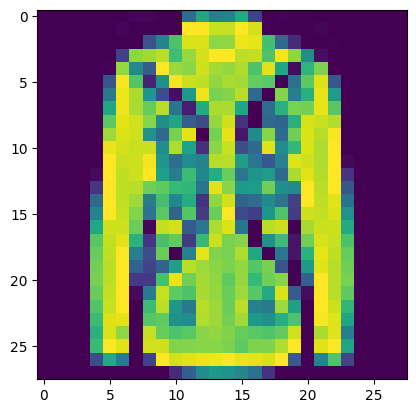

In [10]:
plt.imshow(x.squeeze())

# Model

In [11]:
class ConvNet(nn.Module):
  '''
    Simple Convolutional Neural Network
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Conv2d(channels, 32, kernel_size=3, padding="same"),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, padding="same"),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(width * height * 64, 128),     
#      nn.BatchNorm1d(128),
#      nn.ReLU(),
#      nn.Linear(128, 128),     
#      nn.ReLU(),
      nn.Linear(128, 64),
      nn.Linear(64, 32),
      nn.ReLU(),
      nn.Linear(32, 10)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

In [12]:
# model: nn.Module = ConvNet()

# Tensorboard 

In [13]:
%rm -rf ./logs
# writer = SummaryWriter("./logs")

## Model Grapph

In [14]:
# tensorboard_write_graph(writer=writer, model=model, x=X)

# Hyper Parameters

In [15]:
learning_rates: List[float] = [
    1e-4
]
beta1s: List[float] = [
    0.9, 0.95
]
beta2s: List[float] = [
    0.9985, 0.999
]
decays: List[float] = [
    0.01
]

# Training Loop

In [16]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
prev_loss: float = float(sys.maxsize)
early_stop_tolerance: int = 3

for lr, beta1, beta2, decay in product(learning_rates, beta1s, beta2s, decays):
    print()
    print('-' * 80)
    print(f"lr:{lr} beat1:{beta1} beta2:{beta2} decay:{decay}")
    print('-' * 80)

    # --------------------------------------------------------------------------------
    # Initialize for each parameter combination.
    # --------------------------------------------------------------------------------
    run_name: str = f"./logs/lr{lr}_beat1{beta1}_beta2{beta2}_decay{decay}"
    writer = SummaryWriter(run_name)

    model: nn.Module = ConvNet()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=decay)

    # --------------------------------------------------------------------------------
    # Train for each parameter combination.
    # --------------------------------------------------------------------------------
    for epoch in range(0, 1):   # epochs at maximum
        tensorboard_write_histogram(writer=writer, model=model, step=epoch)
    
        # Print epoch
        print(f'Starting epoch {epoch+1}')
    
        # Reset current loss value at eacch epoch
        _current_loss: float = 0.0
        _num_records: int = 0
    
        # Iterate over the DataLoader for training data
        for index, data in enumerate(train_loader, 0):
            inputs, targets = data
            _batch_size: int = len(inputs)
            _num_records += _batch_size
    
            # Write an image at every batch 0
            if index == 0:
                tensorboard_write_image(writer=writer, tag="image", image=inputs[0], step=epoch, dataformats="CHW")
    
            # Zero the gradients
            optimizer.zero_grad()
    
            # Perform forward pass
            outputs = model(inputs)
    
            # Compute loss
            loss = loss_fn(outputs, targets)
    
            # Perform backward pass
            loss.backward()
    
            # Perform optimization
            optimizer.step()
    
            # Print statistics
            _current_loss += loss.item()
    
            if index % 1000 == 1:
                print('loss after batch %5d: %.3f' % (index, _current_loss / _num_records))

            # if index > 209: break

        # --------------------------------------------------------------------------------
        # Reports per epoch
        # --------------------------------------------------------------------------------
        # Loss
        tensorboard_write_scalar(
            writer=writer, tag="training loss/epoch", value=_current_loss / _num_records, step=epoch
        )
    
        # Validation accuracy & confusion matrix
        with torch.no_grad():
            inputs, labels = next(iter(val_loader))
            predictions = torch.argmax(model(inputs), axis=-1)

        val_loss = loss_fn(predictions.to(torch.float), labels.to(torch.float)) / len(inputs)
        val_acc = get_accuracy(predictions=predictions, truth=labels)
    
        tensorboard_write_scalar(
            writer=writer, tag="validation loss/epoch", value=val_loss, step=epoch
        )
        tensorboard_write_scalar(
            writer=writer, tag="validation accuracy/epoch", value=val_acc, step=epoch
        )
        tensorboard_write_confusion_matrix(
            writer=writer,
            tag="validation confusion matrix",
            predictions=predictions.numpy(),
            truth=labels.numpy(),
            class_names=list(id_to_label.values()),
            step=epoch
        )
        writer.add_hparams(
            hparam_dict={"lr": lr, "beta1": beta1, "beta2": beta2, "decay": decay},
            metric_dict={
                "val_accuracy": val_acc,
                "val_loss": val_loss,
            },
            run_name=run_name,
        )
        print(f'val_acc {val_acc:.03f} val_loss {val_loss: 03f}')

        # --------------------------------------------------------------------------------
        # Early stop
        # --------------------------------------------------------------------------------
        if val_loss > prev_loss:
            early_stop_tolerance -= 1
        else:
            prev_loss = val_loss
    
        if early_stop_tolerance <= 0:
            print("early stop")
            break

    # --------------------------------------------------------------------------------
    # Test
    # --------------------------------------------------------------------------------
    with torch.no_grad():
        inputs, labels = next(iter(test_loader))
        predictions = torch.argmax(model(inputs), axis=-1)

    test_loss = loss_fn(predictions.to(torch.float), labels.to(torch.float)) / len(inputs)
    test_acc = get_accuracy(predictions=predictions, truth=labels)
    print(f'test_acc {test_acc:.03f} test_loss {test_loss: 03f}')

    tensorboard_write_scalar(
        writer=writer, tag="test loss/epoch", value=test_loss, step=epoch
    )
    tensorboard_write_scalar(
        writer=writer, tag="test accuracy/epoch", value=test_acc, step=epoch
    )
    tensorboard_write_confusion_matrix(
        writer=writer,
        tag="test confusion matrix",
        predictions=predictions,
        truth=labels,
        class_names=list(id_to_label.values()),
        step=epoch
    )

# Process is complete.
print('Training process has finished.')


--------------------------------------------------------------------------------
lr:0.0001 beat1:0.9 beta2:0.9985 decay:0.01
--------------------------------------------------------------------------------
Starting epoch 1
loss after batch     1: 0.270
val_acc 0.794 val_loss  43.182842
test_acc 0.799 test_loss  43.310238

--------------------------------------------------------------------------------
lr:0.0001 beat1:0.9 beta2:0.999 decay:0.01
--------------------------------------------------------------------------------
Starting epoch 1
loss after batch     1: 0.299
val_acc 0.766 val_loss  43.933022
test_acc 0.770 test_loss  44.091457

--------------------------------------------------------------------------------
lr:0.0001 beat1:0.95 beta2:0.9985 decay:0.01
--------------------------------------------------------------------------------
Starting epoch 1
loss after batch     1: 0.291
val_acc 0.792 val_loss  44.554764


# Confusion Matrix

In [ ]:
with torch.no_grad():
    inputs, labels = next(iter(test_loader))
    predictions = model(inputs)

In [ ]:
labels = labels.numpy()
predictions = np.argmax(predictions.numpy(), axis=-1).squeeze()

In [ ]:
tensorboard_write_confusion_matrix(
    writer=writer,
    tag="confusion matrix",
    predictions=predictions,
    truth=labels,
    class_names=list(id_to_label.values()),
    step=1
)

# Tensorboard

In [ ]:
%tensorboard --logdir ./logs/